In [1]:
groupvars = {}
with open("Group7_DB_Login.txt") as myfile:
    for line in myfile:
        name, var = line.partition(":")[::2]
        groupvars[name.strip()] = var.strip()

In [2]:
import MySQLdb
conn = MySQLdb.connect(host="localhost", user=groupvars['DB username'], 
                       passwd=groupvars['DB password'], db=groupvars['DB databasename'])
cursor = conn.cursor()

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime
import time
import seaborn as sns
%matplotlib inline
import plotly.graph_objects as go
from plotly.offline import init_notebook_mode, iplot
import plotly.graph_objs as go
import chart_studio.plotly as py
from plotly import subplots
from sklearn.cluster import Birch, MiniBatchKMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler  

### Clustering SNF Facilites by Stay Details, Medicare charges, Distribution of patients by Gender, Ethnicity, Chronic Conditions

In [4]:
snf_cl = pd.read_sql_query("SELECT PRVDR_ID,PRVDR_NAME,PRVDR_CITY,STATE,BENE_DSTNCT_CNT,TOT_EPSD_STAY_CNT,TOT_SRVC_DAYS,TOT_CHRG_AMT,TOT_ALOWD_AMT,TOT_MDCR_PYMT_AMT,TOT_MDCR_STDZD_PYMT_AMT,BENE_AVG_AGE,BENE_MALE_PCT,BENE_FEML_PCT,BENE_RACE_WHT_PCT,BENE_RACE_BLACK_PCT,BENE_RACE_API_PCT,BENE_RACE_HSPNC_PCT,BENE_RACE_NATIND_PCT,BENE_RACE_OTHR_PCT,BENE_AVG_RISK_SCRE,BENE_CC_AF_PCT,BENE_CC_ALZHMR_PCT,BENE_CC_ASTHMA_PCT,BENE_CC_CNCR_PCT,BENE_CC_CHF_PCT,BENE_CC_CKD_PCT,BENE_CC_COPD_PCT,BENE_CC_DPRSSN_PCT,BENE_CC_DBTS_PCT,BENE_CC_IHD_PCT,BENE_CC_OPO_PCT,BENE_CC_RAOA_PCT,BENE_CC_SZ_PCT,BENE_CC_STROK_PCT FROM MD_PAC_SNF_2020 WHERE SMRY_CTGRY = 'PROVIDER'" , conn)
snf_cl = pd.DataFrame(snf_cl)
snf_cl.head()


/usr/local/lib/python3.10/dist-packages/pandas/io/sql.py:761: UserWarning:

pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy



,PRVDR_ID,PRVDR_NAME,PRVDR_CITY,STATE,BENE_DSTNCT_CNT,TOT_EPSD_STAY_CNT,TOT_SRVC_DAYS,TOT_CHRG_AMT,TOT_ALOWD_AMT,TOT_MDCR_PYMT_AMT,...,BENE_CC_CHF_PCT,BENE_CC_CKD_PCT,BENE_CC_COPD_PCT,BENE_CC_DPRSSN_PCT,BENE_CC_DBTS_PCT,BENE_CC_IHD_PCT,BENE_CC_OPO_PCT,BENE_CC_RAOA_PCT,BENE_CC_SZ_PCT,BENE_CC_STROK_PCT
0,25010,KETCHIKAN MED CTR NEW HORIZONS TRANSITIONAL CARE,KETCHIKAN,AK,21,47,693,1464798,502156,442415,...,0.00,0.88,0.00,0.52,0.00,0.61,0.00,0.66,0.00,0.00
1,25018,PROVIDENCE TRANSITIONAL CARE CENTER,ANCHORAGE,AK,159,351,6233,14781270,4211956,3543832,...,0.54,0.88,0.33,0.49,0.47,0.58,0.26,0.64,0.00,0.20
2,25020,DENALI CENTER,FAIRBANKS,AK,75,144,2314,2565277,1483222,1270234,...,0.48,0.61,0.21,0.37,0.45,0.53,0.17,0.42,0.00,0.20
3,25021,HERITAGE PLACE,SOLDOTNA,AK,39,88,1337,1910608,935727,801258,...,0.30,0.46,0.28,0.46,0.41,0.64,0.00,0.88,0.00,0.38
4,25025,PRESTIGE CARE & REHAB CENTER OF ANCHORAGE,ANCHORAGE,AK,172,357,5693,5859756,3972806,3433108,...,0.45,0.73,0.33,0.50,0.46,0.52,0.25,0.61,0.07,0.22


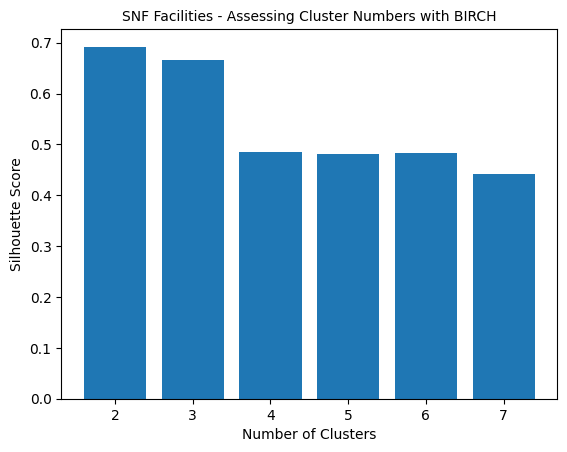

In [5]:
from sklearn.cluster import Birch, MiniBatchKMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import silhouette_samples, silhouette_score

X = snf_cl
X.index = X.PRVDR_ID
X = X.drop(['PRVDR_ID', 'PRVDR_NAME', 'PRVDR_CITY', 'STATE'], axis=1)
X = X.dropna()

birch_silhouette_scores = [] 
for n_cluster in range(2, 8):

    birch_silhouette_scores.append( 
        silhouette_score(X, Birch(n_clusters = n_cluster).fit_predict(X)))       
k = np.arange(2,8)

plt.bar(k, birch_silhouette_scores) 
plt.title('SNF Facilities - Assessing Cluster Numbers with BIRCH', fontsize = 10)
plt.xlabel('Number of Clusters', fontsize = 10) 
plt.ylabel('Silhouette Score', fontsize = 10) 
plt.show()

In [7]:
# apply Birch clustering
from sklearn.cluster import Birch, MiniBatchKMeans
birch1 = Birch(branching_factor=50, n_clusters=2, threshold=1.5)

X['cluster1'] = birch1.fit_predict(X)

# re-fit our model
birch1.fit(X)

# Average silhouette score 
silhouette_score_average1 = silhouette_score(X, birch1.predict(X))

print(silhouette_score_average1)

0.6919852248030971


In [8]:
#To print number of datapoints in each SNF Cluster

snf1 = (X[X['cluster1'] == 0])
snf2 = (X[X['cluster1'] == 1])

print('Size of SNF Clusters:', 'Cluster 1:', len(snf1), ', Cluster 2:', len(snf2))

Size of SNF Clusters: Cluster 1: 1912 , Cluster 2: 12527


### Dimension Reduction with PCA

In [9]:
from sklearn.preprocessing import StandardScaler

xp = StandardScaler().fit_transform(X) # normalizing the features
print(xp.shape)
feat_cols = ['feature'+str(i) for i in range(xp.shape[1])]
norm_xp = pd.DataFrame(xp,columns=feat_cols)
norm_xp.tail()

(14439, 32)


,feature0,feature1,feature2,feature3,feature4,feature5,feature6,feature7,feature8,feature9,...,feature22,feature23,feature24,feature25,feature26,feature27,feature28,feature29,feature30,feature31
14434,0.687630,1.058419,1.293282,0.871859,0.975487,0.884694,1.117964,0.439536,0.162843,0.474731,...,0.021443,0.814088,-0.358657,-0.176306,0.429579,0.535792,-0.176332,-0.699722,-0.472949,-2.559644
14435,-0.786400,-0.744985,-0.661468,-0.589314,-0.578463,-0.574546,-0.658367,0.227358,-2.211643,-2.373675,...,-1.904176,0.158425,0.174005,-0.121256,-1.175644,-1.108463,-0.229192,-0.699722,-1.388676,0.390679
14436,-0.826784,-0.864892,-0.815286,-0.665301,-0.736935,-0.734409,-0.827418,1.288249,0.223727,0.427258,...,-1.320655,0.754483,-0.891318,-2.598510,-0.456061,-1.108463,-0.387771,-0.699722,-1.388676,0.390679
14437,-0.362364,-0.212597,0.050672,-0.029139,0.051942,0.013990,-0.029691,0.015180,-0.141578,0.712098,...,-0.737134,0.873694,-0.944584,-0.506606,0.318874,-1.108463,-1.022091,-0.699722,-1.388676,0.390679
14438,-0.523901,-0.610689,-0.583476,-0.489076,-0.532504,-0.529082,-0.604997,1.288249,-0.202463,0.759572,...,-1.087246,0.158425,-0.252124,-0.671757,0.208169,-1.108463,0.035108,-0.699722,-1.388676,0.390679


In [10]:
from sklearn.decomposition import PCA

for i in range(2,32):
    pca_xp = PCA(n_components=i)
    pcarun_xp = pca_xp.fit_transform(xp)
    fit_xp = pca_xp.fit(xp)
    X["cluster1"].unique()
    norm_xp["cluster1"] = X["cluster1"].values
    var_list = list(pca_xp.explained_variance_ratio_)
    exp_var = sum(var_list)
    if exp_var >= 0.9:
        print('Explained variation per principal component:', var_list)
        print('')
        print('Total variation explained with', i, 'components: ', exp_var)
        break
    i+=1   

Explained variation per principal component: [0.29626352456649874, 0.13599800281525834, 0.11164933056184814, 0.04464113266650494, 0.041616789455086255, 0.037224737155067626, 0.03320897269966897, 0.032396133759102885, 0.02989878771790862, 0.023889728938968693, 0.02349288942049096, 0.01903132486241365, 0.017765023672473703, 0.015535569703103451, 0.013745471191322564, 0.01330348833689909, 0.013063687635142112]

Total variation explained with 17 components:  0.9027245951577586


(14439, 17)
Explained variation for Top 2 principal components: 0.43226152738175705



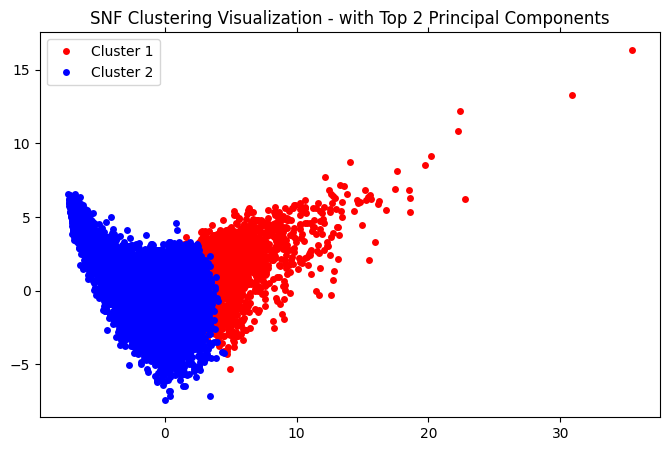

In [11]:
def cluster_visualization(df, columns, labels):
    
    df = df[columns]
    pca = PCA(17)
    pca.fit(df)
    X_PCA = pca.transform(df)
    X_PCA.shape
    print(X_PCA.shape)
    print('Explained variation for Top 2 principal components:', var_list[0] + var_list[1] ) 
    print('')
    
    x, y = X_PCA[:, 0], X_PCA[:, 1] 

    colors = {0: 'red'
              ,1: 'blue'             
             }

    names = {0: 'Cluster 1'
             ,1: 'Cluster 2' 
            }

    df = pd.DataFrame({'x': x, 'y':y, 'label':labels})
    groups = df.groupby('label')

    fig, ax = plt.subplots(figsize=(8, 5)) 

    for name, group in groups:
        ax.plot(group.x, group.y, marker='o', linestyle='', ms=5,
                color=colors[name],label=names[name], mec='none')
        ax.set_aspect('auto')
        ax.tick_params(axis='x',which='both',bottom='off',top='off',labelbottom='off')
        ax.tick_params(axis= 'y',which='both',left='off',top='off',labelleft='off')

    ax.legend()
    ax.set_title("SNF Clustering Visualization - with Top 2 Principal Components")
    plt.show()
    
cluster_visualization(norm_xp, columns = norm_xp.columns[:-1], labels = norm_xp["cluster1"])

In [15]:
# Analyze Distribution of Some Variables for Individual Clusters

import plotly.graph_objects as go

f1 = go.Box(y=snf1['TOT_CHRG_AMT'], name='Cluster 1')
f2 = go.Box(y=snf2['TOT_CHRG_AMT'], name='Cluster 2')
f3 = go.Box(y=snf1['BENE_DSTNCT_CNT'], name='Cluster 1')
f4 = go.Box(y=snf2['BENE_DSTNCT_CNT'], name='Cluster 2')
f5 = go.Box(y=snf1['TOT_SRVC_DAYS'], name='Cluster 1')
f6 = go.Box(y=snf2['TOT_SRVC_DAYS'], name='Cluster 2')
f7 = go.Box(y=snf1['BENE_CC_CNCR_PCT'], name='Cluster 1')
f8 = go.Box(y=snf2['BENE_CC_CNCR_PCT'], name='Cluster 2')


fig = subplots.make_subplots(rows=2, cols=2, print_grid=False, subplot_titles=('SNF Medicare Charges','SNF Patient Counts', 'SNF Service Days','Cancer Patients'))
fig.append_trace(f1, 1, 1);
fig.append_trace(f2, 1, 1);
fig.append_trace(f3, 1, 2);
fig.append_trace(f4, 1, 2);
fig.append_trace(f5, 2, 1);
fig.append_trace(f6, 2, 1);
fig.append_trace(f7, 2, 2);
fig.append_trace(f8, 2, 2);


fig['layout'].update(height=800, width=800, showlegend=False);
iplot(fig, filename='simple-subplot');

### Clustering Hospice Facilites by Stay Details, Medicare charges, Distribution of patients by Gender, Ethnicity, Chronic Conditions

In [16]:
hos_cl = pd.read_sql_query("SELECT DISTINCT PRVDR_ID,PRVDR_NAME,PRVDR_CITY,STATE,BENE_DSTNCT_CNT,TOT_EPSD_STAY_CNT,TOT_SRVC_DAYS,TOT_CHRG_AMT,TOT_ALOWD_AMT, TOT_MDCR_PYMT_AMT, TOT_MDCR_STDZD_PYMT_AMT, BENE_MALE_PCT,BENE_FEML_PCT,BENE_RACE_WHT_PCT, BENE_RACE_BLACK_PCT,BENE_RACE_API_PCT,BENE_RACE_HSPNC_PCT,BENE_RACE_NATIND_PCT,BENE_RACE_OTHR_PCT, BENE_AVG_RISK_SCRE,BENE_PRMRY_DX_CNCR_PCT,BENE_PRMRY_DX_COPD_PCT,BENE_PRMRY_DX_RSPRTRYFAILR_PCT,BENE_PRMRY_DX_DMNT_PCT, BENE_PRMRY_DX_STROK_PCT,BENE_PRMRY_DX_CHF_PCT,BENE_PRMRY_DX_HYPRTNSN_PCT,BENE_PRMRY_DX_OTHRCRDVSCLR_PCT,BENE_PRMRY_DX_INFCTN_PCT, BENE_PRMRY_DX_ORTHO_PCT,BENE_PRMRY_DX_INJURY_PCT,BENE_PRMRY_DX_MTR_NRL_PCT, BENE_PRMRY_DX_DBTS_PCT FROM MD_PAC_HOS_2020 WHERE SMRY_CTGRY = 'PROVIDER' ORDER BY PRVDR_ID, STATE, PRVDR_CITY" , conn)
hos_cl = pd.DataFrame(hos_cl)
hos_cl.head()


/usr/local/lib/python3.10/dist-packages/pandas/io/sql.py:761: UserWarning:

pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy



,PRVDR_ID,PRVDR_NAME,PRVDR_CITY,STATE,BENE_DSTNCT_CNT,TOT_EPSD_STAY_CNT,TOT_SRVC_DAYS,TOT_CHRG_AMT,TOT_ALOWD_AMT,TOT_MDCR_PYMT_AMT,...,BENE_PRMRY_DX_DMNT_PCT,BENE_PRMRY_DX_STROK_PCT,BENE_PRMRY_DX_CHF_PCT,BENE_PRMRY_DX_HYPRTNSN_PCT,BENE_PRMRY_DX_OTHRCRDVSCLR_PCT,BENE_PRMRY_DX_INFCTN_PCT,BENE_PRMRY_DX_ORTHO_PCT,BENE_PRMRY_DX_INJURY_PCT,BENE_PRMRY_DX_MTR_NRL_PCT,BENE_PRMRY_DX_DBTS_PCT
0,101500,COMMUNITY HOSPICE OF NORTHEAST FLORIDA INC,JACKSONVILLE,FL,6928,19590,422327,105703154,79398389,79398389,...,0.19,0.10,0.05,0.00,0.05,0.01,0.0,0.01,0.04,0.0
1,101502,HEARTLAND HOSPICE SERVICES,PLANTATION,FL,886,4268,111468,34766444,18056329,18056329,...,0.16,0.16,0.07,0.00,0.12,0.00,0.0,0.00,0.18,0.0
2,101504,HOSPICE BY THE SEA INC,BOCA RATON,FL,3320,10319,232574,67660868,46495815,46495815,...,0.21,0.09,0.09,0.00,0.12,0.01,0.0,0.00,0.05,0.0
3,101507,LIFEPATH HOSPICE,TAMPA,FL,5913,18013,397823,108821783,72256734,72256734,...,0.25,0.09,0.02,0.08,0.03,0.02,0.0,0.00,0.04,0.0
4,101508,SUNCOAST HOSPICE,CLEARWATER,FL,7705,23511,521160,195150195,96237637,96237637,...,0.15,0.11,0.04,0.08,0.05,0.03,0.0,0.00,0.04,0.0


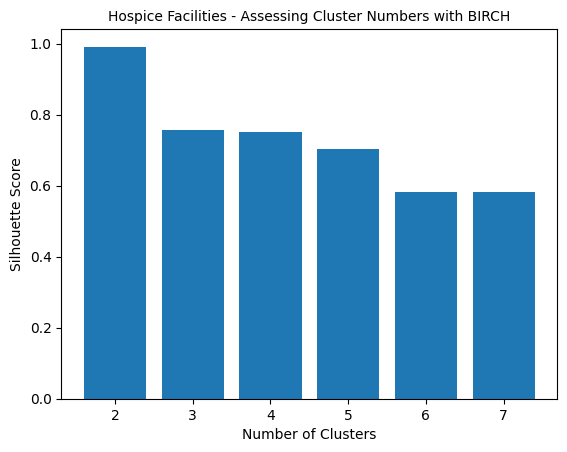

In [17]:
X2 = hos_cl
X2.index = X2.PRVDR_ID
X2 = X2.drop(['PRVDR_ID', 'PRVDR_NAME', 'PRVDR_CITY', 'STATE'], axis=1)
X2 = X2.dropna()

birch_silhouette_scores = [] 

for n_cluster in range(2, 8):
    birch_silhouette_scores.append( 
        silhouette_score(X2, Birch(n_clusters = n_cluster).fit_predict(X2))) 
        
k = np.arange(2,8)

plt.bar(k, birch_silhouette_scores) 
plt.title('Hospice Facilities - Assessing Cluster Numbers with BIRCH', fontsize = 10)
plt.xlabel('Number of Clusters', fontsize = 10) 
plt.ylabel('Silhouette Score', fontsize = 10) 
plt.show()

In [18]:
from sklearn.cluster import Birch, MiniBatchKMeans
birch2 = Birch(branching_factor=50, n_clusters=2, threshold=1.5)

X2['cluster2'] = birch2.fit_predict(X2)

birch1.fit(X2)

silhouette_score_average2 = silhouette_score(X2, birch1.predict(X2))

print(silhouette_score_average2)

0.9912003437764154


In [19]:
#To print number of datapoints in each Hospice Cluster

hos1 = (X2[X2['cluster2'] == 0])
hos2 = (X2[X2['cluster2'] == 1])

print('Size of Hospice Clusters:', 'Cluster 1:', len(hos1), ', Cluster 2:', len(hos2))

Size of Hospice Clusters: Cluster 1: 4689 , Cluster 2: 1


### Dimension Reduction with PCA

In [20]:
from sklearn.preprocessing import StandardScaler

xp2 = StandardScaler().fit_transform(X2) 
print(xp2.shape)
feat_cols2 = ['feature'+str(i) for i in range(xp2.shape[1])]
norm_xp2 = pd.DataFrame(xp2,columns=feat_cols2)
norm_xp2.tail()


(4690, 30)


,feature0,feature1,feature2,feature3,feature4,feature5,feature6,feature7,feature8,feature9,...,feature20,feature21,feature22,feature23,feature24,feature25,feature26,feature27,feature28,feature29
4685,-0.437990,-0.402526,-0.385027,-0.380361,-0.355296,-0.355296,-0.348210,-2.997623,-3.165884,-0.401904,...,-0.770947,-0.856239,-0.481451,-0.554089,-0.306144,-0.085304,-0.158167,-0.61767,-0.04729,-0.014604
4686,-0.444224,-0.411119,-0.394648,-0.388348,-0.366109,-0.366109,-0.355962,-2.997623,-3.165884,0.170733,...,-0.770947,-0.856239,-0.481451,-0.554089,-0.306144,-0.085304,-0.158167,-0.61767,-0.04729,-0.014604
4687,-0.410562,-0.388562,-0.375300,-0.368150,-0.340295,-0.340295,-0.337745,0.076436,0.416190,-0.516431,...,-0.770947,-0.856239,-0.481451,-0.554089,-0.306144,-0.085304,-0.158167,-0.61767,-0.04729,-0.014604
4688,-0.445470,-0.418280,-0.403187,-0.397257,-0.376503,-0.376503,-0.363996,-2.997623,-3.165884,-2.806976,...,-0.770947,-0.856239,-0.481451,-0.554089,-0.306144,-0.085304,-0.158167,-0.61767,-0.04729,-0.014604
4689,-0.440484,-0.411477,-0.395039,-0.392098,-0.366457,-0.366457,-0.356473,-2.997623,-3.165884,-0.134673,...,-0.770947,-0.856239,-0.481451,-0.554089,-0.306144,-0.085304,-0.158167,-0.61767,-0.04729,-0.014604


In [21]:
from sklearn.decomposition import PCA

for i in range(2,30):
    pca_xp2 = PCA(n_components=i)
    pcarun_xp2 = pca_xp2.fit_transform(xp2)
    fit_xp2 = pca_xp2.fit(xp2)
    X2["cluster2"].unique()
    norm_xp2["cluster2"] = X2["cluster2"].values
    var_list2 = list(pca_xp2.explained_variance_ratio_)
    exp_var2 = sum(var_list2)
    if exp_var2 >= 0.9:
        print('Explained variation per principal component:', var_list2)
        print('')
        print('Total variation explained with', i, 'components: ', exp_var2)
        break
    i+=1

Explained variation per principal component: [0.26110897156329044, 0.08973329154713462, 0.06059552132019211, 0.058671313360413806, 0.04378443292283634, 0.04216158060732332, 0.039119119008440444, 0.037951208003986686, 0.03686672605218464, 0.034156482875988874, 0.03292383330665084, 0.03171514086528158, 0.03099190434648272, 0.02795316914736073, 0.02577633279267465, 0.02461796441554363, 0.023961253090050847]

Total variation explained with 17 components:  0.9020882452258362


Explained variation for Top 2 principal components: 0.43226152738175705


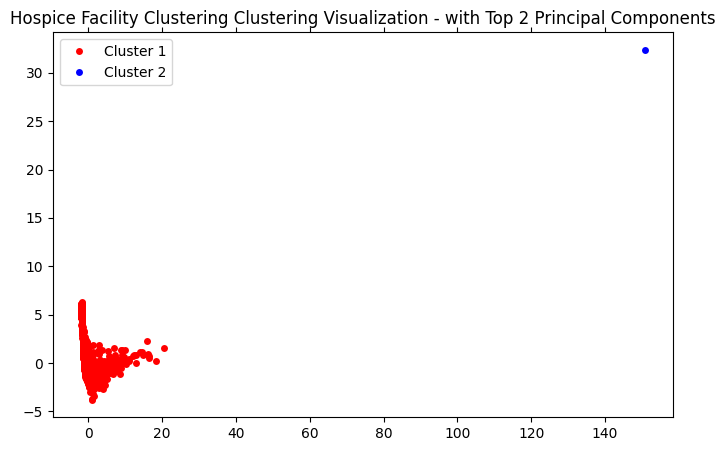

In [22]:
def cluster_visualization(df, columns, labels):
    
    df = df[columns]
    pca = PCA(17)
    pca.fit(df)
    X_PCA = pca.transform(df)
    X_PCA.shape
    print('Explained variation for Top 2 principal components:', var_list[0] + var_list[1])    
    
    x, y = X_PCA[:, 0], X_PCA[:, 1] 

    colors = {0: 'red'
              ,1: 'blue'
             }

    names = {0: 'Cluster 1'
             ,1: 'Cluster 2' 
            }

    df = pd.DataFrame({'x': x, 'y':y, 'label':labels})
    groups = df.groupby('label')

    fig, ax = plt.subplots(figsize=(8, 5)) 

    for name, group in groups:
        ax.plot(group.x, group.y, marker='o', linestyle='', ms=5,
                color=colors[name],label=names[name], mec='none')
        ax.set_aspect('auto')
        ax.tick_params(axis='x',which='both',bottom='off',top='off',labelbottom='off')
        ax.tick_params(axis= 'y',which='both',left='off',top='off',labelleft='off')

    ax.legend()
    ax.set_title("Hospice Facility Clustering Clustering Visualization - with Top 2 Principal Components")
    plt.show()
    
cluster_visualization(norm_xp2, columns = norm_xp2.columns[:-1], labels = norm_xp2["cluster2"])

### Clustering Home Health Facilites by Stay Details, Medicare charges, Distribution of patients by Gender, Ethnicity, Chronic Conditions

In [23]:
hh_cl = pd.read_sql_query("SELECT PRVDR_ID,PRVDR_NAME,PRVDR_CITY,STATE,BENE_DSTNCT_CNT,TOT_EPSD_STAY_CNT,TOT_SRVC_DAYS,TOT_CHRG_AMT,TOT_ALOWD_AMT,TOT_MDCR_PYMT_AMT,TOT_MDCR_STDZD_PYMT_AMT,BENE_AVG_AGE,BENE_MALE_PCT,BENE_FEML_PCT,BENE_RACE_WHT_PCT,BENE_RACE_BLACK_PCT,BENE_RACE_API_PCT,BENE_RACE_HSPNC_PCT,BENE_RACE_NATIND_PCT,BENE_RACE_OTHR_PCT,BENE_AVG_RISK_SCRE,BENE_CC_AF_PCT,BENE_CC_ALZHMR_PCT,BENE_CC_ASTHMA_PCT,BENE_CC_CNCR_PCT,BENE_CC_CHF_PCT,BENE_CC_CKD_PCT,BENE_CC_COPD_PCT,BENE_CC_DPRSSN_PCT,BENE_CC_DBTS_PCT,BENE_CC_IHD_PCT,BENE_CC_OPO_PCT,BENE_CC_RAOA_PCT,BENE_CC_SZ_PCT,BENE_CC_STROK_PCT FROM pachh_2020v2 WHERE SMRY_CTGRY = 'PROVIDER'" , conn)
hh_cl = pd.DataFrame(hh_cl)
hh_cl.head()


/usr/local/lib/python3.10/dist-packages/pandas/io/sql.py:761: UserWarning:

pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy



,PRVDR_ID,PRVDR_NAME,PRVDR_CITY,STATE,BENE_DSTNCT_CNT,TOT_EPSD_STAY_CNT,TOT_SRVC_DAYS,TOT_CHRG_AMT,TOT_ALOWD_AMT,TOT_MDCR_PYMT_AMT,...,BENE_CC_CHF_PCT,BENE_CC_CKD_PCT,BENE_CC_COPD_PCT,BENE_CC_DPRSSN_PCT,BENE_CC_DBTS_PCT,BENE_CC_IHD_PCT,BENE_CC_OPO_PCT,BENE_CC_RAOA_PCT,BENE_CC_SZ_PCT,BENE_CC_STROK_PCT
0,27001,PROVIDENCE IN HOME SERVICES,ANCHORAGE,AK,427,1027,26281,3299904,2218370,2218370,...,0.40,0.60,0.25,0.38,0.44,0.44,0.21,0.63,0.04,0.11
1,27002,HOSPICE & HOME CARE OF JUNEAU,JUNEAU,AK,141,371,9664,812345,756322,756322,...,0.31,0.51,0.28,0.34,0.34,0.34,0.17,0.39,0.00,0.13
2,27006,FAIRBANKS MEMORIAL HOSPITAL HHA,FAIRBANKS,AK,144,360,9452,542215,674040,674040,...,0.36,0.47,0.25,0.28,0.34,0.42,0.13,0.42,0.00,0.18
3,27008,ANCORA HOME HEALTH & HOSPICE,WASILLA,AK,569,1611,42029,5818729,3705798,3705798,...,0.40,0.64,0.34,0.44,0.44,0.49,0.18,0.63,0.03,0.16
4,27009,PETERSBURG MEDICAL CENTER HOME,PETERSBURG,AK,40,177,5071,525420,442058,442058,...,0.52,0.40,0.30,0.42,0.35,0.30,0.00,0.55,0.00,0.00


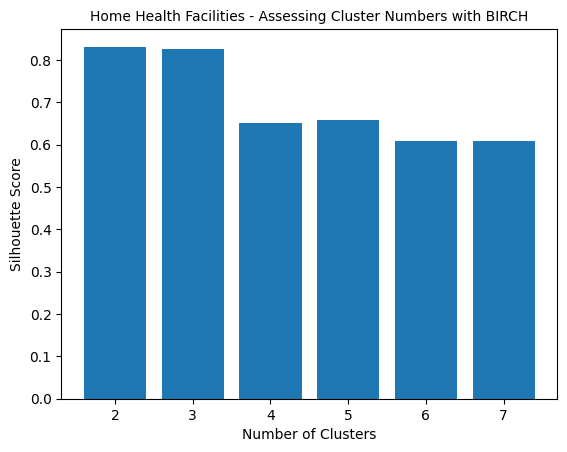

In [24]:
from sklearn.cluster import Birch, MiniBatchKMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import silhouette_samples, silhouette_score


X3 = hh_cl
X3.index = X3.PRVDR_ID
X3 = X3.drop(['PRVDR_ID', 'PRVDR_NAME', 'PRVDR_CITY', 'STATE'], axis=1)
X3 = X3.dropna()


birch_silhouette_scores = [] 

for n_cluster in range(2, 8):

    birch_silhouette_scores.append( 
        silhouette_score(X3, Birch(n_clusters = n_cluster).fit_predict(X3))) 
        
k = np.arange(2,8)

plt.bar(k, birch_silhouette_scores) 
plt.title('Home Health Facilities - Assessing Cluster Numbers with BIRCH', fontsize = 10)
plt.xlabel('Number of Clusters', fontsize = 10) 
plt.ylabel('Silhouette Score', fontsize = 10) 
plt.show()

In [25]:
from sklearn.cluster import Birch, MiniBatchKMeans
birch3 = Birch(branching_factor=50, n_clusters=2, threshold=1.5)

X3['cluster3'] = birch3.fit_predict(X3)

birch3.fit(X3)

silhouette_score_average3 = silhouette_score(X3, birch3.predict(X3))

print(silhouette_score_average3)

0.8312757494752304


In [26]:
#To print number of datapoints in each Home Health Cluster

hh1 = (X3[X3['cluster3'] == 0])
hh2 = (X3[X3['cluster3'] == 1])

print('Size of Home Health Clusters:', 'Cluster 1:', len(hh1), ', Cluster 2:', len(hh2))

Size of Home Health Clusters: Cluster 1: 426 , Cluster 2: 8165


In [27]:
from sklearn.preprocessing import StandardScaler

xp3 = StandardScaler().fit_transform(X3) # normalizing the features
print(xp3.shape)
feat_cols3 = ['feature'+str(i) for i in range(xp3.shape[1])]
norm_xp3= pd.DataFrame(xp3,columns=feat_cols3)
norm_xp3.tail()


(8591, 32)


,feature0,feature1,feature2,feature3,feature4,feature5,feature6,feature7,feature8,feature9,...,feature22,feature23,feature24,feature25,feature26,feature27,feature28,feature29,feature30,feature31
8586,-0.288452,-0.305198,-0.309266,-0.326625,-0.287517,-0.287517,-0.305521,-0.639546,0.559104,0.159608,...,-0.027190,0.863491,0.026074,-0.334349,0.426185,-0.368524,-1.201270,-0.477764,0.509589,0.228416
8587,-0.438394,-0.476084,-0.481729,-0.344885,-0.429441,-0.429441,-0.451256,0.136637,0.342125,0.364027,...,-1.611483,-0.509671,-0.346750,-0.966503,-1.432258,-1.260157,0.041297,-0.477764,-1.163215,0.228416
8588,-0.100645,0.018288,0.037295,-0.126069,-0.003431,-0.003431,-0.009692,-0.639546,0.414451,0.261818,...,-0.534164,0.574405,0.461036,-0.391817,-0.643827,-0.170383,-0.769073,0.470182,0.053370,0.228416
8589,-0.518666,-0.586435,-0.597412,-0.493733,-0.546803,-0.546803,-0.572206,-0.898273,-2.550928,-2.702262,...,-3.576006,-1.955104,-2.459421,-2.690558,-2.952802,-1.260157,-0.012728,-0.477764,-1.163215,0.228416
8590,-0.512608,-0.573824,-0.583571,-0.492346,-0.543642,-0.543642,-0.569138,-0.122091,-2.550928,-2.702262,...,0.289669,-1.955104,-2.459421,-2.690558,-2.952802,-1.260157,-0.661024,-0.477764,-1.163215,0.228416


In [28]:
from sklearn.decomposition import PCA

for i in range(2,32):
    pca_xp3 = PCA(n_components=i)
    pcarun_xp3 = pca_xp3.fit_transform(xp3)
    fit_xp3 = pca_xp3.fit(xp3)
    X3["cluster3"].unique()
    norm_xp3["cluster3"] = X3["cluster3"].values
    var_list3 = list(pca_xp3.explained_variance_ratio_)
    exp_var3 = sum(var_list3)
    if exp_var3 >= 0.9:
        print('Explained variation per principal component:', var_list3)
        print('')
        print('Total variation explained with', i, 'components: ', exp_var3)
        break
    i+=1



Explained variation per principal component: [0.26813690779281374, 0.15745793050420856, 0.09502695352414668, 0.055879999055098724, 0.04939919345028993, 0.04257062665314171, 0.03773829146156685, 0.03279413051054327, 0.029712782594182433, 0.02666367934343155, 0.025869574168497587, 0.020259532238276128, 0.01773386975492922, 0.01643866185541968, 0.0150397954189086, 0.013230800488371268]

Total variation explained with 16 components:  0.9039527288138258


Explained variation for Top 2 principal components: 0.43226152738175705


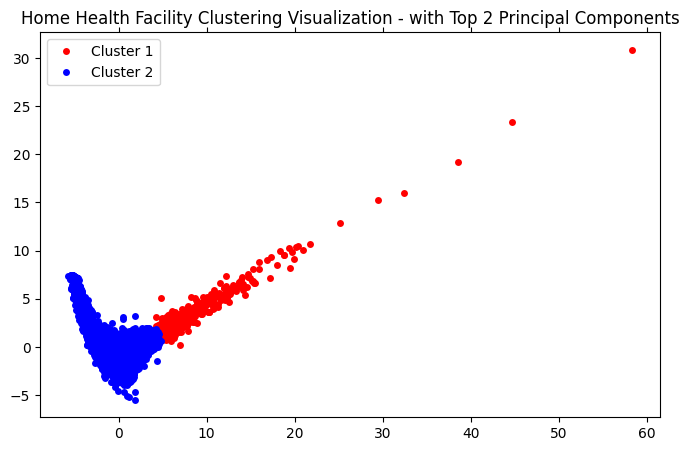

In [29]:
def cluster_visualization(df, columns, labels):
    
    df = df[columns]
    pca = PCA(16)
    pca.fit(df)
    X_PCA = pca.transform(df)
    X_PCA.shape
    print('Explained variation for Top 2 principal components:', var_list[0] + var_list[1])    
    
    x, y = X_PCA[:, 0], X_PCA[:, 1] 

    colors = {0: 'red'
              ,1: 'blue'
             }

    names = {0: 'Cluster 1'
             ,1: 'Cluster 2' 
            }

    df = pd.DataFrame({'x': x, 'y':y, 'label':labels})
    groups = df.groupby('label')

    fig, ax = plt.subplots(figsize=(8, 5)) 

    for name, group in groups:
        ax.plot(group.x, group.y, marker='o', linestyle='', ms=5,
                color=colors[name],label=names[name], mec='none')
        ax.set_aspect('auto')
        ax.tick_params(axis='x',which='both',bottom='off',top='off',labelbottom='off')
        ax.tick_params(axis= 'y',which='both',left='off',top='off',labelleft='off')

    ax.legend()
    ax.set_title("Home Health Facility Clustering Visualization - with Top 2 Principal Components")
    plt.show()
    
cluster_visualization(norm_xp3, columns = norm_xp3.columns[:-1], labels = norm_xp3["cluster3"])

In [30]:
# Analyze Distribution of Some Variables for Individual Clusters

import plotly.graph_objects as go

f1 = go.Box(y=hh1['TOT_CHRG_AMT'], name='Cluster 1')
f2 = go.Box(y=hh2['TOT_CHRG_AMT'], name='Cluster 2')
f3 = go.Box(y=hh1['BENE_DSTNCT_CNT'], name='Cluster 1')
f4 = go.Box(y=hh2['BENE_DSTNCT_CNT'], name='Cluster 2')
f5 = go.Box(y=hh1['TOT_SRVC_DAYS'], name='Cluster 1')
f6 = go.Box(y=hh2['TOT_SRVC_DAYS'], name='Cluster 2')
f7 = go.Box(y=hh1['BENE_CC_CNCR_PCT'], name='Cluster 1')
f8 = go.Box(y=hh2['BENE_CC_CNCR_PCT'], name='Cluster 2')


fig = subplots.make_subplots(rows=2, cols=2, print_grid=False, subplot_titles=('Home Health Medicare Charges','Home Health Patient Counts', 'Home Health Service Days','Cancer Patients'))
fig.append_trace(f1, 1, 1);
fig.append_trace(f2, 1, 1);
fig.append_trace(f3, 1, 2);
fig.append_trace(f4, 1, 2);
fig.append_trace(f5, 2, 1);
fig.append_trace(f6, 2, 1);
fig.append_trace(f7, 2, 2);
fig.append_trace(f8, 2, 2);


fig['layout'].update(height=800, width=800, showlegend=False);
iplot(fig, filename='simple-subplot');

### Clustering Inpatient Rehab Facilites by Stay Details, Medicare charges, Distribution of patients by Gender, Ethnicity, Chronic Conditions

In [31]:
irf_cl = pd.read_sql_query("SELECT PRVDR_ID,PRVDR_NAME,PRVDR_CITY,STATE,BENE_DSTNCT_CNT,TOT_EPSD_STAY_CNT,TOT_SRVC_DAYS,TOT_CHRG_AMT,TOT_ALOWD_AMT,TOT_MDCR_PYMT_AMT,TOT_MDCR_STDZD_PYMT_AMT,BENE_AVG_AGE,BENE_MALE_PCT,BENE_FEML_PCT,BENE_RACE_WHT_PCT,BENE_RACE_BLACK_PCT,BENE_RACE_API_PCT,BENE_RACE_HSPNC_PCT,BENE_RACE_NATIND_PCT,BENE_RACE_OTHR_PCT,BENE_AVG_RISK_SCRE,BENE_CC_AF_PCT,BENE_CC_ALZHMR_PCT,BENE_CC_ASTHMA_PCT,BENE_CC_CNCR_PCT,BENE_CC_CHF_PCT,BENE_CC_CKD_PCT,BENE_CC_COPD_PCT,BENE_CC_DPRSSN_PCT,BENE_CC_DBTS_PCT,BENE_CC_IHD_PCT,BENE_CC_OPO_PCT,BENE_CC_RAOA_PCT,BENE_CC_SZ_PCT,BENE_CC_STROK_PCT FROM pacirf_2020v2 WHERE SMRY_CTGRY = 'PROVIDER'" , conn)
irf_cl = pd.DataFrame(irf_cl)
irf_cl.head()


/usr/local/lib/python3.10/dist-packages/pandas/io/sql.py:761: UserWarning:

pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy



,PRVDR_ID,PRVDR_NAME,PRVDR_CITY,STATE,BENE_DSTNCT_CNT,TOT_EPSD_STAY_CNT,TOT_SRVC_DAYS,TOT_CHRG_AMT,TOT_ALOWD_AMT,TOT_MDCR_PYMT_AMT,...,BENE_CC_CHF_PCT,BENE_CC_CKD_PCT,BENE_CC_COPD_PCT,BENE_CC_DPRSSN_PCT,BENE_CC_DBTS_PCT,BENE_CC_IHD_PCT,BENE_CC_OPO_PCT,BENE_CC_RAOA_PCT,BENE_CC_SZ_PCT,BENE_CC_STROK_PCT
0,20001,PROVIDENCE ALASKA MEDICAL CENTER,ANCHORAGE,AK,40,40,666,5007784,1278230,1252369,...,0.42,0.70,0.00,0.40,0.52,0.52,0.00,0.50,0.00,0.65
1,20017,ALASKA REGIONAL HOSPITAL,ANCHORAGE,AK,98,100,1425,11111476,3609570,3561973,...,0.33,0.57,0.38,0.35,0.48,0.52,0.17,0.63,0.00,0.43
2,10011,ST VINCENT'S EAST,BIRMINGHAM,AL,66,69,885,3705851,1268452,1255648,...,0.51,0.74,0.39,0.51,0.48,0.72,0.00,0.66,0.00,0.45
3,10029,EAST ALABAMA MEDICAL CENTER,OPELIKA,AL,157,168,2239,5437675,3661444,3618984,...,0.54,0.88,0.38,0.44,0.52,0.61,0.15,0.67,0.09,0.36
4,10033,UNIVERSITY OF ALABAMA HOSPITAL,BIRMINGHAM,AL,201,219,3173,16405267,5743019,5571001,...,0.40,0.68,0.27,0.53,0.50,0.62,0.12,0.68,0.00,0.37


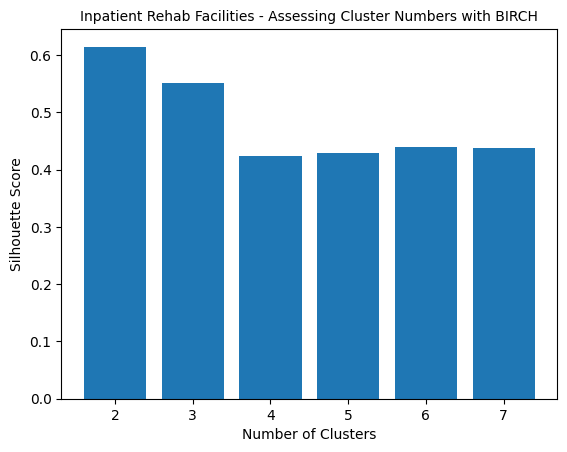

In [32]:
from sklearn.cluster import Birch, MiniBatchKMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import silhouette_samples, silhouette_score


X4 = irf_cl
X4.index = X4.PRVDR_ID
X4 = X4.drop(['PRVDR_ID', 'PRVDR_NAME', 'PRVDR_CITY', 'STATE'], axis=1)
X4 = X4.dropna()


birch_silhouette_scores = [] 

for n_cluster in range(2, 8):

    birch_silhouette_scores.append( 
        silhouette_score(X4, Birch(n_clusters = n_cluster).fit_predict(X4))) 
        
k = np.arange(2,8)

plt.bar(k, birch_silhouette_scores) 
plt.title('Inpatient Rehab Facilities - Assessing Cluster Numbers with BIRCH', fontsize = 10)
plt.xlabel('Number of Clusters', fontsize = 10) 
plt.ylabel('Silhouette Score', fontsize = 10) 
plt.show()

In [33]:
from sklearn.cluster import Birch, MiniBatchKMeans
birch4 = Birch(branching_factor=50, n_clusters=2, threshold=1.5)

X4['cluster4'] = birch4.fit_predict(X4)

birch4.fit(X4)

silhouette_score_average4 = silhouette_score(X4, birch4.predict(X4))

print(silhouette_score_average4)

0.6145210346110722


In [34]:
#To print number of datapoints in each IRF Cluster

irf1 = (X4[X4['cluster4'] == 0])
irf2 = (X4[X4['cluster4'] == 1])

print('Size of IRF Clusters:', 'Cluster 1:', len(irf1), ', Cluster 2:', len(irf2))

Size of IRF Clusters: Cluster 1: 191 , Cluster 2: 907


In [35]:
from sklearn.preprocessing import StandardScaler

xp4 = StandardScaler().fit_transform(X4) 
print(xp4.shape)
feat_cols4 = ['feature'+str(i) for i in range(xp4.shape[1])]
norm_xp4= pd.DataFrame(xp4,columns=feat_cols4)
norm_xp4.tail()

(1098, 32)


,feature0,feature1,feature2,feature3,feature4,feature5,feature6,feature7,feature8,feature9,...,feature22,feature23,feature24,feature25,feature26,feature27,feature28,feature29,feature30,feature31
1093,1.346517,1.460562,1.195376,0.187571,0.743497,0.723405,1.179851,0.337546,-0.899478,0.974024,...,0.020834,1.513271,0.878278,0.200324,0.948980,0.642139,1.835065,0.476162,-0.838130,0.458895
1094,2.201908,2.240807,2.219519,0.808129,1.990271,1.973554,2.404316,0.727678,-0.899478,0.974024,...,1.679768,0.894568,0.415982,0.711849,0.775316,0.390688,1.835065,0.476162,-0.577382,-2.179149
1095,3.188368,3.238795,2.939962,1.290975,2.610396,2.608319,3.169396,-0.442718,-0.270416,0.359169,...,0.370083,0.894568,0.600901,0.609544,0.775316,0.139237,0.625485,0.692653,-0.925045,-2.179149
1096,-0.257342,-0.281381,-0.394680,-0.451541,-0.324870,-0.324512,-0.284074,0.727678,0.107021,-0.009744,...,-1.376163,-0.254452,-0.601069,-1.641165,-1.221811,-0.112214,-0.324900,-0.606293,-0.838130,0.458895
1097,0.580803,0.556324,0.770242,-0.102319,0.648755,0.651770,0.705847,-0.052586,-0.396229,0.482140,...,-1.376163,0.099092,-0.323691,-1.231946,-0.787653,0.390688,-0.411298,-0.606293,-1.185793,0.458895


In [36]:
from sklearn.decomposition import PCA

for i in range(2,32):
    pca_xp4 = PCA(n_components=i)
    pcarun_xp4 = pca_xp4.fit_transform(xp4)
    fit_xp4 = pca_xp4.fit(xp4)
    X4["cluster4"].unique()
    norm_xp4["cluster4"] = X4["cluster4"].values
    var_list4 = list(pca_xp4.explained_variance_ratio_)
    exp_var4 = sum(var_list4)
    if exp_var4 >= 0.9:
        print('Explained variation per principal component:', var_list4)
        print('')
        print('Total variation explained with', i, 'components: ', exp_var4)
        break
    i+=1


Explained variation per principal component: [0.2771490137167613, 0.1430629186282524, 0.1058919275412048, 0.06495007476489725, 0.0455084144550173, 0.03708142469453827, 0.03352443178316087, 0.03142781799177326, 0.030533359480620633, 0.023713373535330765, 0.02206577559163048, 0.020042040830927005, 0.017490094387786072, 0.017183948604678784, 0.015629312138272605, 0.014712875788821007, 0.01301997039825842]

Total variation explained with 17 components:  0.9129867743319311


Explained variation for Top 2 principal components: 0.43226152738175705


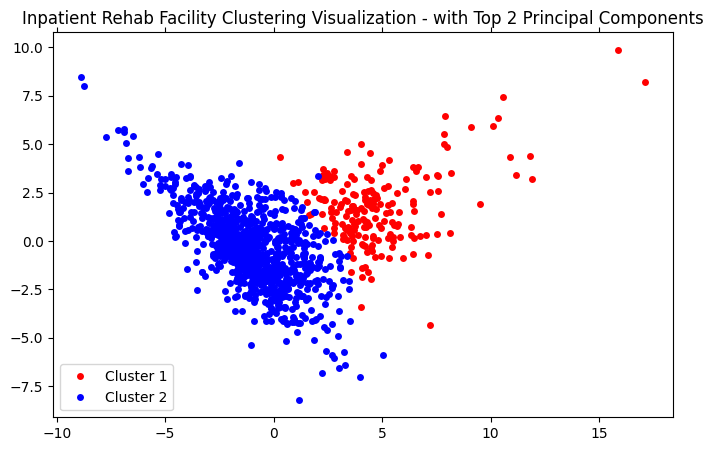

In [37]:
def cluster_visualization(df, columns, labels):
    
    df = df[columns]
    pca = PCA(17)
    pca.fit(df)
    X_PCA = pca.transform(df)
    X_PCA.shape
    print('Explained variation for Top 2 principal components:', var_list[0] + var_list[1])    
    
    x, y = X_PCA[:, 0], X_PCA[:, 1] 

    colors = {0: 'red'
              ,1: 'blue'
             }

    names = {0: 'Cluster 1'
             ,1: 'Cluster 2' 
            }

    df = pd.DataFrame({'x': x, 'y':y, 'label':labels})
    groups = df.groupby('label')

    fig, ax = plt.subplots(figsize=(8, 5)) 

    for name, group in groups:
        ax.plot(group.x, group.y, marker='o', linestyle='', ms=5,
                color=colors[name],label=names[name], mec='none')
        ax.set_aspect('auto')
        ax.tick_params(axis='x',which='both',bottom='off',top='off',labelbottom='off')
        ax.tick_params(axis= 'y',which='both',left='off',top='off',labelleft='off')

    ax.legend()
    ax.set_title("Inpatient Rehab Facility Clustering Visualization - with Top 2 Principal Components")
    plt.show()
    
cluster_visualization(norm_xp4, columns = norm_xp4.columns[:-1], labels = norm_xp4["cluster4"])

In [38]:
# Analyze Distribution of Some Variables for Individual Clusters

import plotly.graph_objects as go

f1 = go.Box(y=irf1['TOT_CHRG_AMT'], name='Cluster 1')
f2 = go.Box(y=irf2['TOT_CHRG_AMT'], name='Cluster 2')
f3 = go.Box(y=irf1['BENE_DSTNCT_CNT'], name='Cluster 1')
f4 = go.Box(y=irf2['BENE_DSTNCT_CNT'], name='Cluster 2')
f5 = go.Box(y=irf1['TOT_SRVC_DAYS'], name='Cluster 1')
f6 = go.Box(y=irf2['TOT_SRVC_DAYS'], name='Cluster 2')
f7 = go.Box(y=irf1['BENE_CC_CNCR_PCT'], name='Cluster 1')
f8 = go.Box(y=irf2['BENE_CC_CNCR_PCT'], name='Cluster 2')


fig = subplots.make_subplots(rows=2, cols=2, print_grid=False, subplot_titles=('IRF Medicare Charges','IRF Patient Counts', 'IRF Service Days','Cancer Patients'))
fig.append_trace(f1, 1, 1);
fig.append_trace(f2, 1, 1);
fig.append_trace(f3, 1, 2);
fig.append_trace(f4, 1, 2);
fig.append_trace(f5, 2, 1);
fig.append_trace(f6, 2, 1);
fig.append_trace(f7, 2, 2);
fig.append_trace(f8, 2, 2);


fig['layout'].update(height=800, width=800, showlegend=False);
iplot(fig, filename='simple-subplot');

### Clustering Longterm Care Facilites by Stay Details, Medicare charges, Distribution of patients by Gender, Ethnicity, Chronic Conditions

In [39]:
ltc_cl = pd.read_sql_query("SELECT PRVDR_ID,PRVDR_NAME,PRVDR_CITY,STATE,BENE_DSTNCT_CNT,TOT_EPSD_STAY_CNT,TOT_SRVC_DAYS,TOT_CHRG_AMT,TOT_ALOWD_AMT,TOT_MDCR_PYMT_AMT,TOT_MDCR_STDZD_PYMT_AMT,BENE_AVG_AGE,BENE_MALE_PCT,BENE_FEML_PCT,BENE_RACE_WHT_PCT,BENE_RACE_BLACK_PCT,BENE_RACE_API_PCT,BENE_RACE_HSPNC_PCT,BENE_RACE_NATIND_PCT,BENE_RACE_OTHR_PCT,BENE_AVG_RISK_SCRE,BENE_CC_AF_PCT,BENE_CC_ALZHMR_PCT,BENE_CC_ASTHMA_PCT,BENE_CC_CNCR_PCT,BENE_CC_CHF_PCT,BENE_CC_CKD_PCT,BENE_CC_COPD_PCT,BENE_CC_DPRSSN_PCT,BENE_CC_DBTS_PCT,BENE_CC_IHD_PCT,BENE_CC_OPO_PCT,BENE_CC_RAOA_PCT,BENE_CC_SZ_PCT,BENE_CC_STROK_PCT FROM pacltc_2020v2 WHERE SMRY_CTGRY = 'PROVIDER'" , conn)
ltc_cl = pd.DataFrame(ltc_cl)
ltc_cl.head()


/usr/local/lib/python3.10/dist-packages/pandas/io/sql.py:761: UserWarning:

pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy



,PRVDR_ID,PRVDR_NAME,PRVDR_CITY,STATE,BENE_DSTNCT_CNT,TOT_EPSD_STAY_CNT,TOT_SRVC_DAYS,TOT_CHRG_AMT,TOT_ALOWD_AMT,TOT_MDCR_PYMT_AMT,...,BENE_CC_CHF_PCT,BENE_CC_CKD_PCT,BENE_CC_COPD_PCT,BENE_CC_DPRSSN_PCT,BENE_CC_DBTS_PCT,BENE_CC_IHD_PCT,BENE_CC_OPO_PCT,BENE_CC_RAOA_PCT,BENE_CC_SZ_PCT,BENE_CC_STROK_PCT
0,22001,ST ELIAS SPECIALTY HOSPITAL,ANCHORAGE,AK,91,96,4896,27069125,8941912,7895922,...,0.52,0.88,0.45,0.56,0.58,0.60,0.00,0.52,0.00,0.17
1,12006,INFIRMARY LTAC HOSPITAL,MOBILE,AL,142,146,3584,12530069,5488005,5271195,...,0.61,0.88,0.42,0.50,0.70,0.88,0.09,0.54,0.09,0.21
2,12007,"NOLAND HOSPITAL MONTGOMERY II, LLC",MONTGOMERY,AL,92,96,2484,9743752,4022735,3745469,...,0.88,0.88,0.48,0.45,0.69,0.69,0.13,0.55,0.00,0.29
3,12008,SELECT SPECIALTY HOSPITAL - BIRMINGHAM,BIRMINGHAM,AL,154,157,4546,41612575,7526436,6596144,...,0.70,0.88,0.57,0.53,0.63,0.67,0.07,0.58,0.11,0.31
4,12009,"NOLAND HOSPITAL BIRMINGHAM II, LLC",BIRMINGHAM,AL,165,171,4034,13730113,6142023,5820196,...,0.60,0.88,0.49,0.66,0.62,0.69,0.09,0.53,0.10,0.23


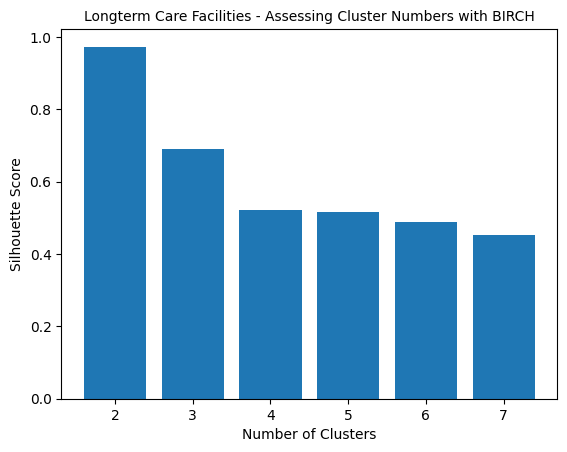

In [40]:
from sklearn.cluster import Birch, MiniBatchKMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import silhouette_samples, silhouette_score


X5 = ltc_cl
X5.index = X5.PRVDR_ID
X5 = X5.drop(['PRVDR_ID', 'PRVDR_NAME', 'PRVDR_CITY', 'STATE'], axis=1)
X5 = X5.dropna()


birch_silhouette_scores = [] 

for n_cluster in range(2, 8):

    birch_silhouette_scores.append( 
        silhouette_score(X5, Birch(n_clusters = n_cluster).fit_predict(X5))) 
        
k = np.arange(2,8)

plt.bar(k, birch_silhouette_scores) 
plt.title('Longterm Care Facilities - Assessing Cluster Numbers with BIRCH', fontsize = 10)
plt.xlabel('Number of Clusters', fontsize = 10) 
plt.ylabel('Silhouette Score', fontsize = 10) 
plt.show()

In [41]:
from sklearn.cluster import Birch, MiniBatchKMeans
birch5 = Birch(branching_factor=50, n_clusters=2, threshold=1.5)

X5['cluster5'] = birch5.fit_predict(X5)

birch5.fit(X5)

silhouette_score_average5 = silhouette_score(X5, birch5.predict(X5))

print(silhouette_score_average5)

0.9728511899645085


In [42]:
from sklearn.preprocessing import StandardScaler

xp5 = StandardScaler().fit_transform(X5) # normalizing the features
print(xp5.shape)
feat_cols5 = ['feature'+str(i) for i in range(xp5.shape[1])]
norm_xp5= pd.DataFrame(xp5,columns=feat_cols5)
norm_xp5.tail()

(352, 32)


,feature0,feature1,feature2,feature3,feature4,feature5,feature6,feature7,feature8,feature9,...,feature22,feature23,feature24,feature25,feature26,feature27,feature28,feature29,feature30,feature31
347,-0.362900,-0.327780,-0.383970,-0.210477,-0.211699,-0.196968,-0.300487,-0.955950,-0.118913,0.414027,...,0.214566,-0.484966,-0.205001,-0.418112,-0.101168,-0.346308,-0.651262,-1.152417,-0.617542,-0.053376
348,0.152310,0.059563,0.240281,0.042746,0.168373,0.152007,0.424960,-0.955950,-0.118913,0.414027,...,0.214566,1.065164,0.424042,0.007866,1.173051,-0.689207,-0.206128,0.624156,-0.157976,-0.053376
349,0.202575,0.124120,0.145100,0.076518,0.102570,0.121116,0.306452,-0.252722,-0.018294,0.301315,...,0.214566,1.065164,0.334179,0.078862,1.173051,-0.346308,1.040249,0.387280,-0.502651,-0.053376
350,-1.273941,-1.092533,-1.307927,-0.465069,-1.251399,-1.257831,-1.407065,-1.659177,-5.250473,-4.996187,...,-6.438485,-3.520637,-5.147479,-4.606894,-4.728594,-1.717904,-4.924553,-1.152417,-2.800483,-0.053376
351,-0.991204,-0.864100,-1.112921,-0.417692,-1.115165,-1.115931,-1.211848,-0.252722,0.484800,-0.262249,...,0.214566,0.935986,0.244316,0.078862,1.173051,-1.717904,-0.028074,-1.152417,-2.800483,-0.053376


In [43]:
from sklearn.decomposition import PCA

for i in range(2,32):
    pca_xp5 = PCA(n_components=i)
    pcarun_xp5 = pca_xp5.fit_transform(xp5)
    fit_xp5 = pca_xp5.fit(xp5)
    X5["cluster5"].unique()
    norm_xp5["cluster5"] = X5["cluster5"].values
    var_list5 = list(pca_xp5.explained_variance_ratio_)
    exp_var5 = sum(var_list5)
    if exp_var5 >= 0.9:
        print('Explained variation per principal component:', var_list5)
        print('')
        print('Total variation explained with', i, 'components: ', exp_var5)
        break
    i+=1

Explained variation per principal component: [0.29708384994574755, 0.14966452488174373, 0.08332540302187992, 0.06013744112151598, 0.04736650254085654, 0.04135498260832566, 0.03662405442054808, 0.035288356002439576, 0.02909143744786021, 0.028487919272435765, 0.023814876537603526, 0.022680479927394068, 0.020012446740098246, 0.01827209499865776, 0.01505134820000009]

Total variation explained with 15 components:  0.9082557176671069


Explained variation for Top 2 principal components: 0.43226152738175705


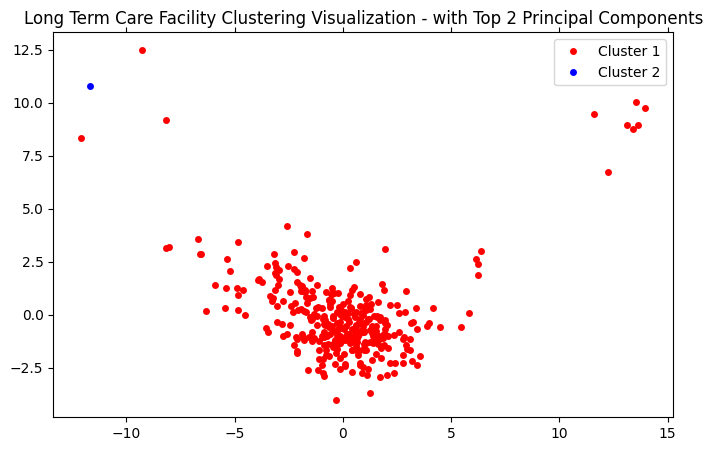

In [44]:
def cluster_visualization(df, columns, labels):
    
    df = df[columns]
    pca = PCA(17)
    pca.fit(df)
    X_PCA = pca.transform(df)
    X_PCA.shape
    print('Explained variation for Top 2 principal components:', var_list[0] + var_list[1])    
    
    x, y = X_PCA[:, 0], X_PCA[:, 1] 

    colors = {0: 'red'
              ,1: 'blue'
             }

    names = {0: 'Cluster 1'
             ,1: 'Cluster 2' 
            }

    df = pd.DataFrame({'x': x, 'y':y, 'label':labels})
    groups = df.groupby('label')

    fig, ax = plt.subplots(figsize=(8, 5)) 

    for name, group in groups:
        ax.plot(group.x, group.y, marker='o', linestyle='', ms=5,
                color=colors[name],label=names[name], mec='none')
        ax.set_aspect('auto')
        ax.tick_params(axis='x',which='both',bottom='off',top='off',labelbottom='off')
        ax.tick_params(axis= 'y',which='both',left='off',top='off',labelleft='off')

    ax.legend()
    ax.set_title("Long Term Care Facility Clustering Visualization - with Top 2 Principal Components")
    plt.show()
    
cluster_visualization(norm_xp5, columns = norm_xp5.columns[:-1], labels = norm_xp5["cluster5"])